# Noise analysis for 3 nominally identical 3D printers case study

written by Christina Schenk

last updated on 16 Oct 2025

tested on Christina's Mac

This notebook performs noise analysis and generates associated plots for the case study of 3 nominally identical 3D printers presented in "Noise-Aware Optimization in Nominally Identical Measuring Systems for High-Throughput Parallel Workflows Manuscript" by Christina Schenk et al. (2025).

The main steps of the workflow are the following:
 1. Calculate noise statistics and format data frame
 2. Generate box plot for simultaneous and sequential noise
 3. Generate KDE plot of noise for different distributions of weight
 4. Calculate pairwise divergence metrics
 5. KMeans Clustering and Plots

### Import python packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba
import numpy as np
import seaborn as sns
# Custom legend
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from scipy.stats import ks_2samp
from numpy import histogram, sqrt
from scipy.special import rel_entr
from scipy.stats import wasserstein_distance
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

import statsmodels.api as sm
from statsmodels.formula.api import ols

### Import data

In [2]:
# Load first 226 rows
df = pd.read_excel("../data/3printers_Oct2024_data_noise_reformattedtasks_all.xlsx", nrows=225)

In [3]:
# Melt the dataframe from wide to long format for the 3 printers
long_df = pd.melt(df, id_vars=['Flow', 'LH', 'Rep_sim', 'Rep_seq'],
                  value_vars=['W_P1', 'W_P2', 'W_P3'],
                  var_name='Printer', value_name='Weight')

### 1. Calculate noise and format data frame for plotting and some calculations

In [4]:
# Calculate std (noise) grouped by Flow, LH, and Rep_sim (simultaneous noise)
sim_noise = df.groupby(['Flow', 'LH', 'Rep_seq'])[['W_P1', 'W_P2', 'W_P3']].std().reset_index()
sim_noise = sim_noise.rename(columns={'W_P1': 'W_P1_sim_noise', 'W_P2': 'W_P2_sim_noise', 'W_P3': 'W_P3_sim_noise'})

# Calculate std (noise) grouped by Flow, LH, and Rep_seq (sequential noise)
seq_noise = df.groupby(['Flow', 'LH', 'Rep_sim'])[['W_P1', 'W_P2', 'W_P3']].std().reset_index()
seq_noise = seq_noise.rename(columns={'W_P1': 'W_P1_seq_noise', 'W_P2': 'W_P2_seq_noise', 'W_P3': 'W_P3_seq_noise'})

# To combine into one dataframe for plotting, you can first reshape to long format
sim_noise_long = pd.melt(sim_noise, id_vars=['Flow', 'LH', 'Rep_seq'], 
                         value_vars=['W_P1_sim_noise', 'W_P2_sim_noise', 'W_P3_sim_noise'], 
                         var_name='Printer', value_name='Noise')
sim_noise_long['Rep_type'] = 'Simultaneous'
sim_noise_long['Rep_index'] = sim_noise_long['Rep_seq']
sim_noise_long['Printer'] = sim_noise_long['Printer'].str.replace('_sim_noise', '')

seq_noise_long = pd.melt(seq_noise, id_vars=['Flow', 'LH', 'Rep_sim'], 
                         value_vars=['W_P1_seq_noise', 'W_P2_seq_noise', 'W_P3_seq_noise'], 
                         var_name='Printer', value_name='Noise')
seq_noise_long['Rep_type'] = 'Sequential'
seq_noise_long['Rep_index'] = seq_noise_long['Rep_sim']
seq_noise_long['Printer'] = seq_noise_long['Printer'].str.replace('_seq_noise', '')

# Combine both for plotting
noise_combined = pd.concat([sim_noise_long, seq_noise_long], ignore_index=True)

# Drop old repetition columns to tidy up
noise_combined = noise_combined.drop(columns=['Rep_sim', 'Rep_seq'])

noise_combined['Printer'] = noise_combined['Printer'].str.replace('W_', '')



### 2. Generate box plot of simultaneous and sequential noise

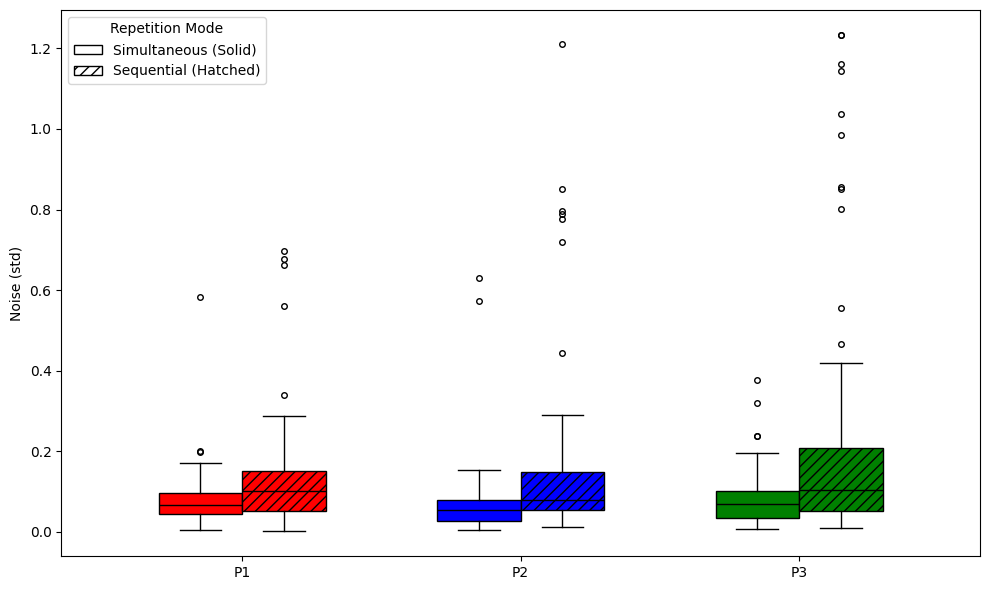

In [5]:
printers = ['P1', 'P2', 'P3']
colors = {'P1': 'red', 'P2': 'blue', 'P3': 'green'}
modes = ['Simultaneous', 'Sequential']

fig, ax = plt.subplots(figsize=(10, 6))

x_positions = {printer: i for i, printer in enumerate(printers)}
width = 0.3
offsets = {'Simultaneous': -width/2, 'Sequential': width/2}

for printer in printers:
    for mode in modes:
        subset = noise_combined[(noise_combined['Printer'] == printer) & (noise_combined['Rep_type'] == mode)]
        if subset.empty:
            continue
        pos = x_positions[printer] + offsets[mode]
        hatch = '///' if mode == 'Sequential' else None

        if len(subset) > 1:
            ax.boxplot(
                subset['Noise'],  # use the CV column here
                positions=[pos],
                widths=width,
                patch_artist=True,
                boxprops=dict(
                    facecolor=to_rgba(colors[printer]),
                    edgecolor='black',
                    hatch=hatch
                ),
                medianprops=dict(color='black'),
                whiskerprops=dict(color='black'),
                capprops=dict(color='black'),
                flierprops=dict(marker='o', color='black', markersize=4, linestyle='none')
            )
        else:
            ax.scatter([pos]*len(subset), subset['CV'], color=colors[printer], marker='o')

ax.set_xticks(list(x_positions.values()))
ax.set_xticklabels(printers)
ax.set_ylabel("Noise (std)")

legend_elements = [
    Patch(facecolor='white', edgecolor='black', label='Simultaneous (Solid)'),
    Patch(facecolor='white', edgecolor='black', hatch='///', label='Sequential (Hatched)')
]
ax.legend(handles=legend_elements, title='Repetition Mode')

plt.tight_layout()
plt.savefig("Figures_NoiseAnalysis/noisedist_boxplot.png", format='png', dpi=600)
plt.show()


## 3. Generate KDE plot of noise for different printers

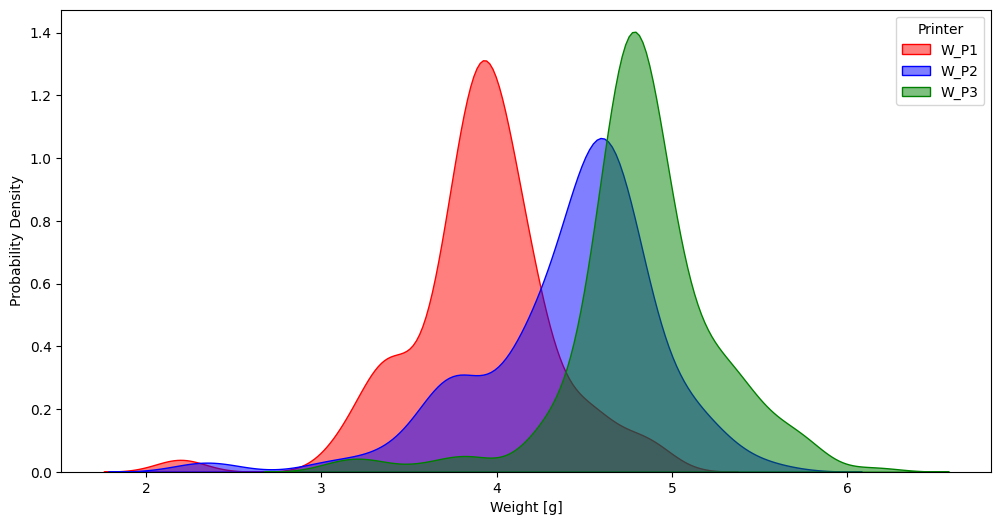

In [6]:
# Optionally, you can plot KDE for each printer output individually to compare.
# For example, comparing noise distributions for each printer output across Rep_seq:
plt.figure(figsize=(12, 6))
sns.kdeplot(df['W_P1'], label='W_P1', color='red', fill=True, alpha=0.5)
sns.kdeplot(df['W_P2'], label='W_P2', color='blue', fill=True, alpha=0.5)
sns.kdeplot(df['W_P3'], label='W_P3', color='green', fill=True, alpha=0.5)

#plt.title('KDE Plot: Printer Outputs (W_P1, W_P2, W_P3) Distribution')
plt.ylabel('Probability Density')
plt.xlabel('Weight [g]')
plt.legend(title="Printer")
plt.savefig("Figures_NoiseAnalysis/noisedist_kdeplot.png", format='png', dpi=600)
plt.show()


In [7]:
#Method	Interpretation
#KDE Plot	Large overlap = good candidate for grouping

## 4. Calculate pairwise divergence metrics

### 4.1 Kolmogorov-Smirnov Test 

In [8]:
#KS Test	p-value > 0.05 → no significant difference, ks stat close to 0 very similar, significantly larger than 0, very different
# Assuming df contains W_P1, W_P2, W_P3
printers = ['W_P1', 'W_P2', 'W_P3']
pairs = [(a, b) for i, a in enumerate(printers) for b in printers[i+1:]]

# Kolmogorov–Smirnov Test
print("\n Kolmogorov–Smirnov Test Results:")
for a, b in pairs:
    ks_stat, p_value = ks_2samp(df[a].dropna(), df[b].dropna(), method='asymp')
    print(f"{a} vs {b}: KS statistic = {ks_stat:.4f}, p-value = {p_value:.16f}")



 Kolmogorov–Smirnov Test Results:
W_P1 vs W_P2: KS statistic = 0.5867, p-value = 0.0000000000000000
W_P1 vs W_P3: KS statistic = 0.8311, p-value = 0.0000000000000000
W_P2 vs W_P3: KS statistic = 0.4711, p-value = 0.0000000000000000


### 4.2 Bhattacharyya Distance

In [9]:
# Bhattacharyya Distance (simple approximation via histograms) 
# Lower distance = more similar distributions
print("\n Approximate Bhattacharyya Distance:")
def bhattacharyya_dist(x, y, bins=50):
    hist_x, _ = histogram(x, bins=bins, density=True)
    hist_y, _ = histogram(y, bins=bins, density=True)
    return -np.log(np.sum(sqrt(hist_x * hist_y)))

for a, b in pairs:
    dist = bhattacharyya_dist(df[a].dropna(), df[b].dropna())
    print(f"{a} vs {b}: Bhattacharyya distance = {dist:.4f}")


 Approximate Bhattacharyya Distance:
W_P1 vs W_P2: Bhattacharyya distance = -2.7003
W_P1 vs W_P3: Bhattacharyya distance = -2.6519
W_P2 vs W_P3: Bhattacharyya distance = -2.5194


### 4.3 Wasserstein Distance

In [10]:
printers = ['W_P1', 'W_P2', 'W_P3']
pairs = [(a, b) for i, a in enumerate(printers) for b in printers[i+1:]]

print("\n Wasserstein Distance Between Printers:")
for a, b in pairs:
    d = wasserstein_distance(df[a].dropna(), df[b].dropna())
    print(f"{a} vs {b}: Wasserstein Distance = {d:.4f}")

#measures how much "effort" it takes to move one distribution into the shape of another. Very intuitive and works well on continuous data.
#small Similar distributions	large Different shapes/means
# Close to 0/<0.1 → Very similar distributions.
#~0.1–0.5 → Small but noticeable differences.
#> 1.0 → Substantial difference in shape or mean.

#Pair	Distance	Interpretation
#W_P1 vs W_P2	0.51	Moderate difference
#W_P2 vs W_P3	0.42	Moderate difference
#W_P1 vs W_P3	0.93	Substantial difference
#Takeaway: W_P1 and W_P3 are the most dissimilar in shape or central tendency.



 Wasserstein Distance Between Printers:
W_P1 vs W_P2: Wasserstein Distance = 0.5052
W_P1 vs W_P3: Wasserstein Distance = 0.9268
W_P2 vs W_P3: Wasserstein Distance = 0.4224


### 4.4 Kullback-Leibler Divergence

In [11]:
def compute_kl(p, q, bins=100):
    # Histogram to estimate PDF (density=True normalizes it)
    p_hist, bin_edges = np.histogram(p.dropna(), bins=bins, density=True)
    q_hist, _ = np.histogram(q.dropna(), bins=bin_edges, density=True)

    # Add small constant to avoid division by zero
    p_hist += 1e-10
    q_hist += 1e-10

    # Normalize to make proper probability distributions
    p_hist /= p_hist.sum()
    q_hist /= q_hist.sum()

    # Compute KL divergence
    return np.sum(rel_entr(p_hist, q_hist))

print("\n Kullback–Leibler Divergence (KL):")
for a, b in pairs:
    kl_ab = compute_kl(df[a], df[b])
    kl_ba = compute_kl(df[b], df[a])
    print(f"{a} → {b}: KL = {kl_ab:.4f}, {b} → {a}: KL = {kl_ba:.4f}")


 Kullback–Leibler Divergence (KL):
W_P1 → W_P2: KL = 7.9755, W_P2 → W_P1: KL = 6.8787
W_P1 → W_P3: KL = 15.1497, W_P3 → W_P1: KL = 12.7176
W_P2 → W_P3: KL = 5.1161, W_P3 → W_P2: KL = 3.4149


## 5. KMeans Clustering and Plots

In [12]:
# Aggregate descriptive statistics per printer per Flow, LH
features = long_df.groupby(['Printer', 'Flow', 'LH'])['Weight'].agg(['mean', 'std', 'var']).reset_index()

# Prepare feature matrix for clustering (drop non-numeric grouping columns)
X = features[['mean', 'std', 'var']]

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Set number of clusters (e.g., 3 clusters)
k = 3
kmeans = KMeans(n_clusters=k, random_state=42)
features['Cluster'] = kmeans.fit_predict(X_scaled)
print(features)

   Printer         Flow        LH      mean       std       var  Cluster
0     W_P1  1228.346948  0.399158  3.792222  0.056064  0.003143        0
1     W_P1  1294.000000  0.550000  3.854778  0.102728  0.010553        0
2     W_P1  1379.000000  0.520000  3.811444  0.083618  0.006992        0
3     W_P1  1674.837963  0.554071  3.435889  0.049172  0.002418        0
4     W_P1  1889.632451  0.242580  2.979444  0.588561  0.346405        2
..     ...          ...       ...       ...       ...       ...      ...
70    W_P3  4586.000000  0.390000  4.901667  0.083159  0.006915        1
71    W_P3  4670.899219  0.234590  4.860556  0.055824  0.003116        1
72    W_P3  4707.000000  0.420000  5.404889  0.121197  0.014689        1
73    W_P3  4738.000000  0.480000  5.293778  0.151321  0.022898        1
74    W_P3  4949.227855  0.225241  4.809667  0.087856  0.007719        1

[75 rows x 7 columns]


### 5.1. Count plot for counts in clusters and box plot for how the noise of the printers is distributed in the clusters 

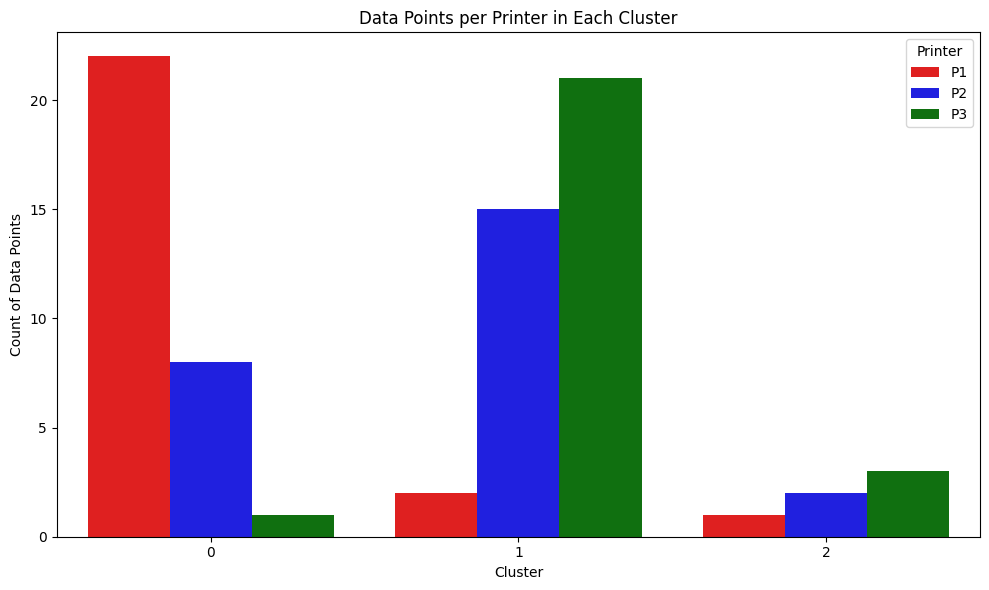

In [13]:
features['Printer'] = features['Printer'].str.replace('W_', '')
colors = {'P1': 'red', 'P2': 'blue', 'P3': 'green'}
plt.figure(figsize=(10, 6))
sns.countplot(data=features, x='Cluster', hue='Printer', palette=colors)
plt.xlabel('Cluster')
plt.ylabel('Count of Data Points')
plt.title('Data Points per Printer in Each Cluster')
plt.legend(title='Printer')
plt.tight_layout()
plt.savefig("Figures_NoiseAnalysis/KMeans_3Clusters_countplot.png", format='png', dpi=600)
plt.show()

### 5.2 Scatter plot of noise in associated colors of printers and markers for clusters

#### 5.2.1 Scatter plot of noise vs. experimental point index in associated colors of printers and markers for clusters

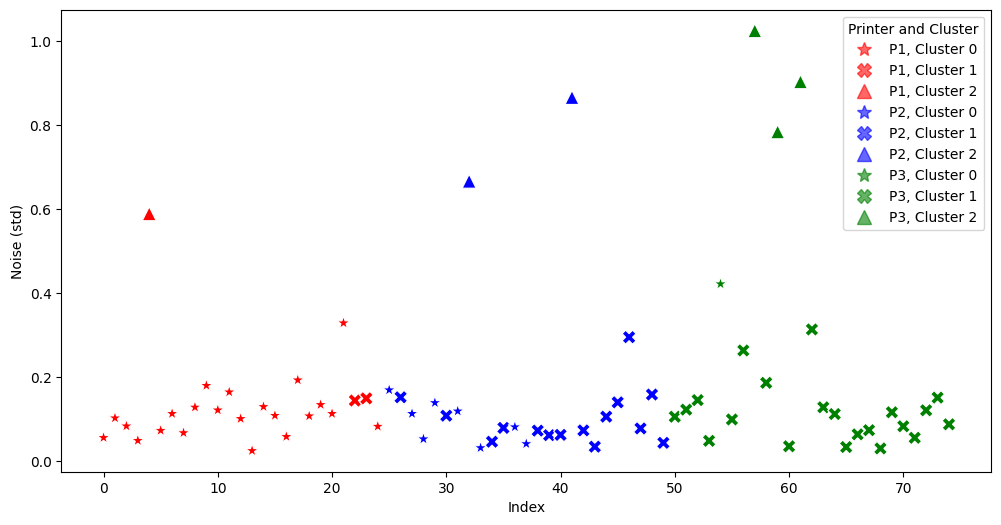

In [14]:
# cluster scatter plot colored by printer association and marked by cluster 
markers = ["*", "X", "^"]
printers = ['P1', 'P2', 'P3']
clusters = [0, 1, 2]

plt.figure(figsize=(12, 6))
sns.scatterplot(
    x=features.index,
    y=features['std'],
    hue=features['Printer'],        # Color points by printer
    style=features['Cluster'],      # Different marker shape for each cluster
    palette=colors,       # Use the manual palette
    s=100,
    markers = markers   # Example markers: circle, square, diamond for 3 clusters
)
#plt.title('Noise (Std Dev) Colored by Printer with Cluster Markers')
plt.xlabel('Index')
plt.ylabel('Noise (std)')
# Create combined legend handles
combined_handles = []
for printer in printers:
    for cluster, marker in zip(clusters, markers):
        combined_handles.append(
            mlines.Line2D(
                [], [],
                color=colors[printer],
                marker=marker,
                linestyle='None',
                markersize=10,
                alpha=0.6,
                label=f'{printer}, Cluster {cluster}'
            )
        )

# Add one combined legend
plt.legend(handles=combined_handles, title='Printer and Cluster', loc='best', bbox_to_anchor=None)
plt.savefig("Figures_NoiseAnalysis/KMeans_indexvsNoise_3ClustersPrintersScatterPlot.png", format='png', dpi=600)
plt.show()


#### 5.2.2 Scatter plot of noise vs. mean weight in associated colors of printers and markers for clusters

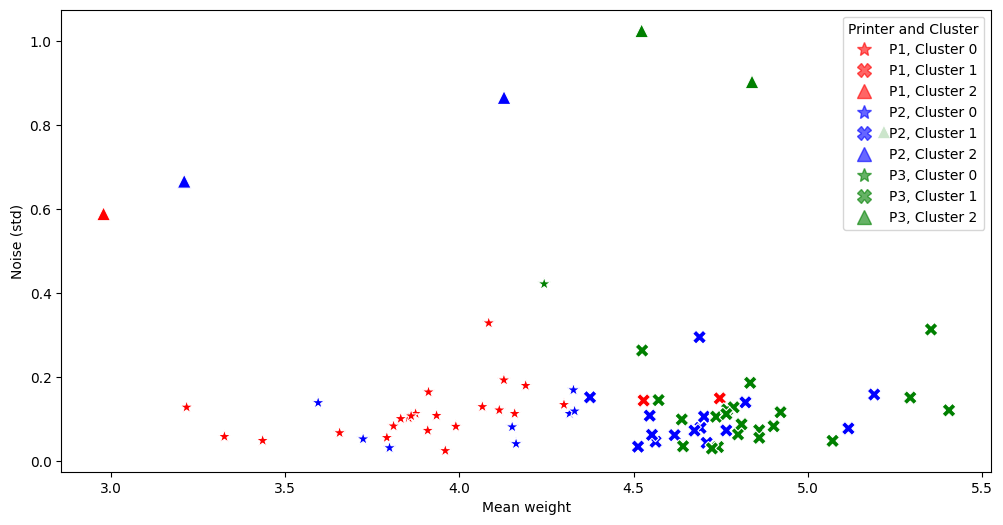

In [15]:
# cluster scatter plot colored by printer association and marked by cluster 
markers = ["*", "X", "^"]
printers = ['P1', 'P2', 'P3']
clusters = [0, 1, 2]

plt.figure(figsize=(12, 6))
sns.scatterplot(
    x=features['mean'],
    y=features['std'],
    hue=features['Printer'],        # Color points by printer
    style=features['Cluster'],      # Different marker shape for each cluster
    palette=colors,       # Use the manual palette
    s=100,
    markers = markers   # Example markers: circle, square, diamond for 3 clusters
)
#plt.title('Noise (Std Dev) Colored by Printer with Cluster Markers')
plt.xlabel('Mean weight')
plt.ylabel('Noise (std)')
# Create combined legend handles
combined_handles = []
for printer in printers:
    for cluster, marker in zip(clusters, markers):
        combined_handles.append(
            mlines.Line2D(
                [], [],
                color=colors[printer],
                marker=marker,
                linestyle='None',
                markersize=10,
                alpha=0.6,
                label=f'{printer}, Cluster {cluster}'
            )
        )

# Add one combined legend
plt.legend(handles=combined_handles, title='Printer and Cluster', loc='best', bbox_to_anchor=None)
plt.savefig("Figures_NoiseAnalysis/KMeans_MeanWeightvsNoisePrinters_3ClustersScatterPlot.png", format='png', dpi=600)
plt.show()
